# NON-PPMS Heat Capacity

This notebook computes heat capacity of data taken on $\rm{Yb_2Ti_2O_7}$, but the data is in a simplified non-PPMS format. This is so that heat capacity data taken without a PPMS can be processed with LongHCPulse. (With the special class LongHCPulse_NonPPMS)
The main difference is that the wire conductivity as a function of temperature must be supplied separately, and the temperature correction from resistivity is not applied. 

This notebook is for the purposes of illustration only; the lack of temperature correction renders data taken on a PPMS unreliable.

#### The data file must be formatted as follows:

Each pulse must have this as a header

```
BEGIN:PULSE:PARAMS
NBinsOn= ?? (number of data points taken while the heater is on)
NBinsOff= ??  (number of data points taken while the heater is off)
SystemTemp= ??  (base temperature)
Field= ??   (applied magnetic field)
END:PULSE:PARAMS
```

Then, the data must be listed immediately after this header in the format 
```
time (s), sample temperature (K), heater power (W)
```

In [1]:
# import libraries
%matplotlib notebook
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.lines as mlines
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import ScalarFormatter
import sys
from LongHCPulse_NonPPMS import LongHCPulse_NonPPMS # class to compute heat capacity

In [2]:

# Find Yb2Ti2O7 molar mass
mmYb = 173.201 	# g/mol   (from WolframAlpha.com)
mmTi = 47.867	# g/mol
mmO = 15.9994	# g/mol
MMYbTiO = (2*mmYb + 2*mmTi + 7*mmO)

# Import data and compute heat capacity (this can take a minute or two)
datafile = 'YbTi2O7_nonppms_longpulse.dat'
WireConductivity = 'wireConductivity.dat'
YbTiO = LongHCPulse_NonPPMS(datafile=datafile, thermcond=WireConductivity,
	sampmass=1.04,molarmass=MMYbTiO)   # sample mass is in mg

# Compute Heat Capacity
YbTiO.heatcapacity(smoothlevel=0)
# Scale data to per Yb ion instead of per F.U.:
YbTiO.scale(2)

**************** LongHCPulse v 1.3.2 *****************
 please cite   https://arxiv.org/pdf/1705.07129.pdf
******************************************************
 - Importing data...
 100%
 - Computing Heat Capacity...
 100%


In [6]:
#****************************************************
####Scale magnetic fields by demagnetization factor:
#****************************************************

#Formula unit volume   (unit cell volume divided by 8, becuase there are 16 Yb ions per unit cell)
FUvol =  10.01247e-10 **3 / 8 #(m^3)
mu_B = 9.27401e-24
mu0 = 4*np.pi*1e-7

magvsfield = 'YbTiO_MvsB_100mK.txt'
MvsB = np.genfromtxt(magvsfield, skip_header=1, unpack=True)
MvsB[1] = MvsB[1]*mu_B/FUvol  #convert to A/m from mu_B/F.U.
MvsB[0] = MvsB[0] - mu0*1/3*MvsB[1]   # Correct for sphere demagnetization (!)
MvsB[0] = MvsB[0]*10000  #convert to Oe from T

#plt.figure()
#plt.plot(MvsB[0],MvsB[1])
DemagFactor = 0.6

YbTiO.scaleDemagFactor(demagFac = DemagFactor, magvsfield = MvsB)

Scaling demagnetization...


# Plot Data

<IPython.core.display.Javascript object>


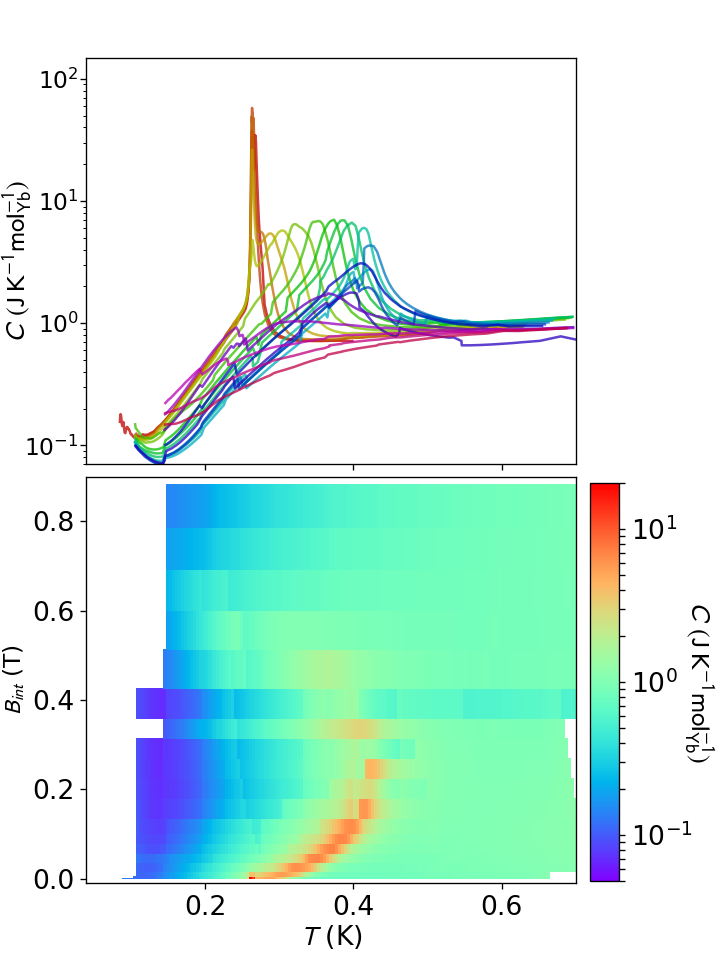

/home/allen/Documents/Python/Modules/LongHCPulse_NonPPMS.py:848: RuntimeWarning: Mean of empty slice
  AvgBinnedHc = np.nanmean(binnedhc, axis=0)


(0.04, 0.7)

In [7]:
# Clear labels
YbTiO.labels = []

params = {'text.usetex': False, 'mathtext.fontset': 'stixsans', 'font.size': 16}
plt.rcParams.update(params)

#***************
# Plot the HC data in mesh grid form
#***************

f, ax = plt.subplots(2,1,sharex=True,figsize=(6,8))

xarray = np.arange(0.0,0.9,0.004)
intens, Bedg = YbTiO.meshgrid(Tarray =xarray,Barray='All')

meshdata = ax[1].pcolormesh(xarray,Bedg/10000,intens,rasterized = True, 
	cmap = 'rainbow', norm=LogNorm(vmin=0.05, vmax=20))

ax[1].set_ylabel('$B_{int}$ (T)',fontsize=14,labelpad = 4)
ax[1].set_ylim(-100./10000,9000/10000.)
ax[1].set_xlabel("$T$ (K)", labelpad = 1) 

##### Colorscale bar
cax = f.add_axes([0.82,0.082,0.04,0.415])
f.subplots_adjust(left = 0.12,right = 0.80, bottom = 0.08, top = 0.94,wspace =0.02,
                  hspace = 0.03)
cb=plt.colorbar(meshdata,cax=cax)
cb.set_label('$C$ $(\\rm{J\> K^{-1} mol^{-1}_{Yb}})$', rotation = -90, labelpad = 14)


#********************************************
# Plot the HC data in line plots
#***************

YbTiO.lineplotCombine(ax[0],'all',smooth=0, demag=False)

ax[0].set_ylabel("$C$ $(\\rm{J\> K^{-1} mol^{-1}_{Yb}})$", labelpad = -6)
ax[0].set_yscale('log')
ax[0].tick_params(axis='y', which='major', pad=1, labelsize=14)

ax[0].set_ylim(0.07,149)
ax[0].set_xlim(0.04,0.7)

## Note:
The data looks like a mess and the lines don't all align because the temperature correction was not made in creating this data file. This is a problem unique to the PPMS, and so the NonPPMS version does not make this correction.

If data had been taken on some other instrument, this correction would likely not be necessary and the data would come out fine. This notebook is for the purposes of illustration.